In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 32.8 MB/s 


In [3]:
%load_ext autotime

time: 759 µs (started: 2022-09-09 19:45:33 +00:00)


# Cargar modelos

In [4]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 32.6 MB/s 
time: 4.45 s (started: 2022-09-09 19:45:33 +00:00)


In [5]:
# Install dependencies
#!pip install albumentations==0.4.6
!pip install albumentations
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'vision'...
remote: Enumerating objects: 209184, done.
remote: Counting objects: 100% (1726/1726), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 209184 (delta 1564), reused 1705 (delta 1553), pack-reused 207458
Receiving objects: 100% (209184/209184), 418.70 MiB | 23.49 MiB/s, done.
Resolving deltas: 100% (188853/188853), done.
/content/vision
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version
/content
time:

In [6]:
# imporar librerias
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from torchvision import transforms 
from torch import nn, optim
import torch.optim as optim
from torchvision.models import resnet101
import urllib.request
import cv2

from ignite.metrics import ClassificationReport
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

from genericpath import exists

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

time: 4.21 s (started: 2022-09-09 19:46:33 +00:00)


In [7]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


time: 1.15 s (started: 2022-09-09 19:46:37 +00:00)


In [8]:
from torchvision.models import resnext101_32x8d
resnext1 = resnext101_32x8d(pretrained=True)
resnext2 = resnext101_32x8d(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

time: 6.92 s (started: 2022-09-09 19:46:38 +00:00)


In [11]:
# Cargar backbone resnet y resnext
class MultilabelClassifier1(nn.Module):
    def __init__(self, n_classes, pretrain_model):
        super().__init__()
        self.pretrain_model = pretrain_model
        self.model_wo_fc = nn.Sequential(*(list(self.pretrain_model.children())[:-1]))

        self.classes = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=2048, out_features=n_classes)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return {
            'label': self.classes(x)
        }

time: 8.18 ms (started: 2022-09-09 19:46:55 +00:00)


In [12]:
device = 'cuda'
PATH_1 = '/content/drive/MyDrive/Falabella/ML definitive models/mlc_model_4.pth'
ml_model_1 = MultilabelClassifier1(3, resnext1).to(device)
ml_model_dict_1 = torch.load(PATH_1, map_location=torch.device(device))
ml_model_1.load_state_dict(ml_model_dict_1['model_state_dict'])
#ml_model_1.eval()

<All keys matched successfully>

time: 6.92 s (started: 2022-09-09 19:46:57 +00:00)


In [ ]:
ml_model_dict_1['validation loss']

In [24]:
# obtener epoca óptima
optimal_epoch = ml_model_dict_1['epoch']
print(optimal_epoch)

6
time: 768 µs (started: 2022-09-09 19:05:10 +00:00)


In [13]:
# Cargar backbone -> para modelo 'mlc_model_baseline_data_revisada_1_2.pth'
class MultilabelClassifier2(nn.Module):
    def __init__(self, n_classes, pretrain_model):
        super().__init__()
        self.pretrain_model = pretrain_model
        self.model_wo_fc = nn.Sequential(*(list(self.pretrain_model.children())[:-1]))

        self.classes = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=2048, out_features=3)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return {
            'label': self.classes(x)
        }

time: 1.49 ms (started: 2022-09-09 19:47:04 +00:00)


In [14]:
device = 'cuda'
PATH_2 = '/content/drive/MyDrive/Falabella/mlc_model_baseline_data_revisada_1_2.pth'
ml_model_2 = MultilabelClassifier2(3, resnext2).to(device)
ml_model_dict_2 = torch.load(PATH_2, map_location=torch.device(device))
ml_model_2.load_state_dict(ml_model_dict_2['model_state_dict'])
#ml_model_2.eval()

<All keys matched successfully>

time: 13.2 s (started: 2022-09-09 19:47:08 +00:00)


In [27]:
ml_model_dict_2['validation loss']

2.0754197467943256

time: 3.84 ms (started: 2022-09-09 19:05:21 +00:00)


In [28]:
# obtener epoca óptima
optimal_epoch = ml_model_dict_2['epoch']
print(optimal_epoch)

10
time: 884 µs (started: 2022-09-09 19:05:24 +00:00)


In [15]:
# REFERENCIAR!
# función de ayuda para cargar modelo
def get_object_detection_model(num_classes):
  # load a model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

time: 1.14 ms (started: 2022-09-09 19:47:27 +00:00)


In [16]:
# cargar modelo ya entrenado con cuda
model_path = '/content/drive/MyDrive/Falabella/OD definitive models/model_cf_12y3_1.pth'
num_classes = 2
od_model = get_object_detection_model(num_classes)
od_model_dict = torch.load(model_path)
od_model.load_state_dict(od_model_dict['model_state_dict'])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

<All keys matched successfully>

time: 6.05 s (started: 2022-09-09 19:47:34 +00:00)


In [16]:
# cargar modelo ya entrenado con cpu
model_path = '/content/drive/MyDrive/Falabella/OD definitive models/model_cf_12y3_1.pth'
num_classes = 2
od_model = get_object_detection_model(num_classes)
od_model_dict = torch.load(model_path, map_location=torch.device('cpu'))
od_model.load_state_dict(od_model_dict['model_state_dict'])


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

<All keys matched successfully>

time: 5.99 s (started: 2022-09-09 19:33:14 +00:00)


# Función de score

In [15]:
# Librerias
import pandas as pd
import numpy as np
import os
import io
import cv2
import urllib
import math
import urllib.request

time: 916 µs (started: 2022-09-09 18:03:54 +00:00)


In [ ]:
# función para calcular accuracy 1:1, obtener true_labels, predicciones
# y scores
import os
from skimage import io, transform

def od_acc_1000_test(model, path_images, path_xlsx, device = 'cuda'):
  acc = 0
  df = pd.read_excel(path_xlsx)
  model.to(device)
  model.eval()              # turn the model to evaluate mode
  count = 0
  #y_test = []
  y_true = []
  y_pred = []
  y_score = []
  aciertos = 0
  with torch.no_grad():
    for img_name in os.listdir(path_images):
      full_img_name = os.path.join(path_images, img_name)
      image =io.imread(full_img_name)
      t_img = transform.resize(image, (480, 480))
      t_img = torch.Tensor(t_img).permute(2,0,1).to(device)
      prediction = model([t_img])
      if prediction[0]['labels'].shape[0] > 0 and max(prediction[0]['scores']).item() >= 0.5:
      #if prediction[0]['labels'].shape[0] > 0: 
        pred_class = 1
      else:
        pred_class = 0
      y_pred.append(pred_class)
      indice = int(img_name.split('.')[0])
      true_class = df.loc[indice]['Producto']
      #y_test.append(true_class)
      y_true.append(true_class)
      if prediction[0]['labels'].shape[0] > 0:
        y_score.append(max(prediction[0]['scores']).item())
      else:
        y_score.append(0)
      if pred_class == true_class:
        aciertos += 1
      else:
        pass
      count+=1
    acc = aciertos/count

    return acc, y_true, y_pred, y_score

In [ ]:
# función para calcular accuracy 1:1
import os
from skimage import io, transform
import matplotlib.pyplot as plt


ml_model.to(device)
ml_model.eval()              # turn the model to evaluate mode
od_model.to(device)
od_model.eval()

# transformación para clasificador
transformations = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                      std=[0.229, 0.224, 0.225]),
                                                 ])
with torch.no_grad():
  fig, a = plt.subplots(1,1)
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Frimadariagao%40ttereyes.cl%2F149069566635.png?alt=media&token=6764bf1c-f8e7-493c-9194-42ec5f5ad7ec'
  url2 = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fraacevedo%40flopar.cl%2F149069331320.png?alt=media&token=770b7a57-f22f-40f7-9c34-6a41c2d1631d'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Figespinosa%40flopar.cl%2F149069510494.png?alt=media&token=07e1ceb4-2c58-4e64-88c6-123df2c8f6bb'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Figespinosa%40flopar.cl%2F14906952340301.png?alt=media&token=3bc3a521-640a-4c9e-947a-017fcb45d2b8'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fcrbello%40flopar.cl%2F149069579237.png?alt=media&token=ff5ece1b-b2b5-413f-9946-b77e2a93000b'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fmmonjev%40atenas.cl%2F149070535524.png?alt=media&token=1e855f19-d25f-4c78-b13b-e9dc737d9521'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fpacantillana%40atenas.cl%2F149070498375.png?alt=media&token=aad3d701-6636-4ff2-ba05-75f09fc37cd8'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fpagallegos%40transantino.cl%2F149070471763.png?alt=media&token=c09460a8-e0b2-4194-886b-48c0a31ceb7f'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fpacortes%40transantino.cl%2F149070466427.png?alt=media&token=7fe9102b-b10e-4cd1-be63-dd6a1279850d'
  # leer url y obtener imagen
  url_open = urllib.request.urlopen(url2)
  image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
  image = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
  #-----------------------------------------------------------------------------
  # CLASIFICADOR MULTI-ETIQUETA
  # transformación para aplicar clasificador
  t_img = transformations(image)
  img = t_img.unsqueeze(dim = 0)
  # obtener clasificación
  label_base = ml_model(img.to(device))
  score = torch.sigmoid(label_base['label'])
  label = score.round()
  # lista de predicciones
  ml_prediction = label[0].tolist()
  #-----------------------------------------------------------------------------
  # DETECTOR DE OBJETOS
  # transformación para aplicar detector
  t_img = transform.resize(image, (480, 480))
  t_img = torch.Tensor(t_img).permute(2,0,1).to(device)
  od_prediction = od_model([t_img])

  if od_prediction[0]['labels'].shape[0] > 0 and max(od_prediction[0]['scores']).item() >= 0.5:
    pred_class = 1
  else:
    pred_class = 0  
  plt.imshow(t_img.permute(1,2,0).to('cpu'))
  boxes = od_prediction[0]['boxes'].to(device)
  scores = od_prediction[0]['scores']
  scores = torch.where(scores > 0.5, 1, 0)
  indice = 0
  for score in od_prediction[0]['scores']:
    if score >= 0.5:
      box = boxes[indice]
      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle(
          (x.item(), y.item()),
          width.item(), height.item(),
          linewidth = 2,
          edgecolor = 'b',
          facecolor = 'none'
          )
        # Draw the bounding box on top of the image
      print(type(a))
      a.add_patch(rect) 
    indice+=1  
  plt.show()

{'label': tensor([[-2.3492, -7.0706, -4.3919]], device='cuda:0')}
tensor([[0.0871, 0.0008, 0.0122]], device='cuda:0')
tensor([[0., 0., 0.]], device='cuda:0')
480
1
tensor([[ 80.8282,   8.8799, 478.8388, 346.8514],
        [122.8723,  13.0691, 473.5590, 202.6768],
        [178.1047,  84.9059, 467.3821, 228.2464]], device='cuda:0')


RuntimeError: ignored

In [ ]:
# REFERENCIAR
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min x-max y-max
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  
  plt.show()

In [ ]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target, axs, i, j, device, prediction = None):
  axs[i,j].imshow(img.to(device))
  
  if prediction:
    boxes = target['boxes'].to(device)
    indice = 0
    for score in target['scores']:
      if score >= 0.5:
        box = boxes[indice]
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle(
          (x, y),
          width, height,
          linewidth = 2,
          edgecolor = 'b',
          facecolor = 'none'
        )
        # Draw the bounding box on top of the image
        axs[i,j].add_patch(rect) 
      indice+=1      
  
  else:
    for box in (target['boxes'].to(device)):
      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle(
        (x, y),
        width, height,
        linewidth = 2,
        edgecolor = 'r',
        facecolor = 'none'
      )
      # Draw the bounding box on top of the image
      axs[i,j].add_patch(rect)

In [ ]:
import itertools
from google.colab.patches import cv2_imshow
# supuesto: tabla con enlaces a cada fotografía

def score(url, classificator_1, pesos = {'w_prod': 0.3, 'w_notface': 0.1,
                                                 'w_label': 0.3, 'w_num': 0.1, 'w_contx': 0.2},
          thresholds = {'t_prod': 0.5, 't_face': 0.5, 't_label': 0.5, 't_num': 0.5, 't_ctx_down': 0.15, 
                        't_ctx_up': 0.6}):
  """
  Args:
      url (str): url donde se encuentra la imagen
      pesos (dict): diccionario con valores para cada peso, es decir,
      w_prod (product), w_notface (without face), w_label (product label), 
      w_num (address number) y w_contx (context)
      thresholds = diccionario con valores de umbral para cada criterio, es decir,
      t_prod (product), t_face (face detector), t_label (product label) y 
      t_num (address number)

  Returns:
      model_dict (dict): toda la info. del modelo entrenado    
  """
  # evaluar con gpu si es posible o si no cpu
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  classificator_1.to(device)
  classificator_1.eval()           
  #detector.to(device)
  #detector.eval()
  # transformación para clasificador
  transformations = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                      std=[0.229, 0.224, 0.225]),
                                                 ])
  with torch.no_grad():
    # Obtener imagen
    url_open = urllib.request.urlopen(url)
    image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
    image = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2_imshow(image)
    #-----------------------------------------------------------------------------
    # CLASIFICADOR MULTI-ETIQUETA
    # transformación para aplicar clasificador
    t_img = transformations(image)
    img = t_img.unsqueeze(dim = 0)
    # obtener clasificación
    label_base = classificator_1(img.to(device))
    # obtener score
    score = torch.sigmoid(label_base['label']).squeeze()
    print(score)

    return

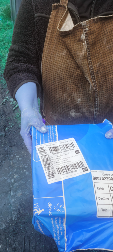

tensor([1.0000, 0.0074, 0.0774], device='cuda:0')


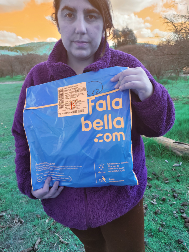

tensor([0.9948, 0.0030, 0.9377], device='cuda:0')


tensor([0.9994, 0.0024, 0.9073], device='cuda:0')


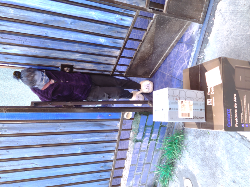

tensor([0.9595, 0.2293, 0.2695], device='cuda:0')


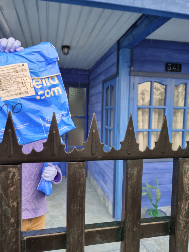

tensor([0.9974, 0.0845, 0.0880], device='cuda:0')


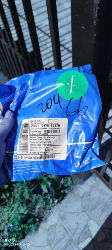

tensor([1.0000, 0.0058, 0.0566], device='cuda:0')


tensor([0.9069, 0.2823, 0.9397], device='cuda:0')


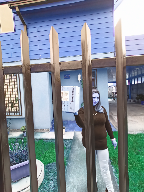

tensor([0.7772, 0.2021, 0.8205], device='cuda:0')


tensor([1.2915e-01, 9.8865e-04, 9.9363e-01], device='cuda:0')


KeyboardInterrupt: ignored

In [ ]:
# Prueba de modelo con dataset test_125_corregido mas id
test_125 = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido.xlsx')
df_base = pd.DataFrame(columns = ['id', 'url','Paquete', 'Etiqueta producto', 'Sin rostro',\
                                                'Numero domicilio', 'Contexto', 'Score'])

for i in range(len(test_125)):
  url = test_125.iloc[i]['Imageurl']
  name = test_125.iloc[i]['id']
  value = [name,url]
  df1 = pd.DataFrame(columns = ['id','url']) 
  df1.loc[0] = value
  #aplicar modelo que retornara df2
  #df2, _, _ = score(url, ml_model_1, ml_model_2, od_model, thresholds = { 't_prod': 0.9046,'t_face': 0.6491,'t_label': 0.1831,'t_num': 0.4287 })
  score(url, ml_model_1)
  #df3 = pd.concat((df1,df2), axis =1)
  #df_base = pd.concat((df_base,df3), ignore_index= True)

print('Se ejecutó el modelo exitosamente')        
#descargar df_base como excel
#se especifica nombre del archivo
file_name = 'resultados_modelo_id.xlsx'
  
#guardar excel
df_base.to_excel(file_name)
print('Archivo excel se exportó correctamente')

In [32]:
import itertools
from google.colab.patches import cv2_imshow
# supuesto: tabla con enlaces a cada fotografía

def score(url, PATH_1, PATH_2, detector, pesos = {'w_prod': 0.3, 'w_notface': 0.1,
                                                 'w_label': 0.3, 'w_num': 0.1, 'w_contx': 0.2},
          thresholds = {'t_prod': 0.5, 't_face': 0.5, 't_label': 0.5, 't_num': 0.5, 't_ctx_down': 0.15, 
                        't_ctx_up': 0.6}):
  """
  Args:
      url (str): url donde se encuentra la imagen
      pesos (dict): diccionario con valores para cada peso, es decir,
      w_prod (product), w_notface (without face), w_label (product label), 
      w_num (address number) y w_contx (context)
      thresholds = diccionario con valores de umbral para cada criterio, es decir,
      t_prod (product), t_face (face detector), t_label (product label) y 
      t_num (address number)

  Returns:
      model_dict (dict): toda la info. del modelo entrenado    
  """
  # evaluar con gpu si es posible o si no cpu
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  #device = torch.device('cpu')

  ##classificator_1.to(device)
  ##classificator_1.eval()  
  ##classificator_2.to(device)
  ##classificator_2.eval()            
  detector.to(device)
  detector.eval()
  # transformación para clasificador
  transformations = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                      std=[0.229, 0.224, 0.225]),
                                                 ])
  with torch.no_grad():
    # Obtener imagen
    url_open = urllib.request.urlopen(url)
    image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
    image = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ##cv2_imshow(image)
    #-----------------------------------------------------------------------------
    # CLASIFICADOR MULTI-ETIQUETA
    # transformación para aplicar clasificador
    t_img = transformations(image)
    img = t_img.unsqueeze(dim = 0)
    # obtener clasificación
    #---------------------------clasificador 1--------------------------------
    ##PATH_1 = '/content/drive/MyDrive/Falabella/ML definitive models/mlc_model_4.pth'
    classificator_1 = MultilabelClassifier(3, resnext).to(device)
    classificator_1_dict = torch.load(PATH_1, map_location=device)
    classificator_1.load_state_dict(classificator_1_dict['model_state_dict'])
    classificator_1.to(device)
    classificator_1.eval() 
    label_base = classificator_1(img.to(device))
    #---------------------------clasificador 2--------------------------------
    ##PATH_2 = '/content/drive/MyDrive/Falabella/mlc_model_baseline_data_revisada_1_2.pth'
    classificator_2 = MultilabelClassifier(3, resnext).to(device)
    classificator_2_dict = torch.load(PATH_2, map_location=device)
    classificator_2.load_state_dict(classificator_2_dict['model_state_dict'])
    classificator_2.to(device)
    classificator_2.eval()
    label_etiqueta = classificator_2(img.to(device))
    # obtener score
    score = torch.sigmoid(label_base['label']).squeeze()
    ##print(score)
    score_etiqueta = torch.sigmoid(label_etiqueta['label']).squeeze()
    ##print(score_etiqueta)
    # analizar score para 'etiqueta'
    if score_etiqueta[0].item() >= thresholds['t_label']:
      etiqueta = 1
    else:
      etiqueta = 0
    # analizar score para 'n° domicilio'
    if score[1].item() >= thresholds['t_num']:
      domicilio = 1
    else:
      domicilio = 0
    # analizar score para 'cara'
    if score[2].item() >= thresholds['t_face']:
      no_cara = 0
      ##cara = 1
    else:
      no_cara = 1
      ##cara = 0
    # lista de predicciones
    ##ml_prediction = [etiqueta, domicilio, cara]
    ##print(ml_prediction)
    #-----------------------------------------------------------------------------
    # DETECTOR DE OBJETOS
    # transformación para aplicar detector
    t_img_0 = transform.resize(image, (480, 480))
    # obtener area de la imagen
    area_img = t_img_0.shape[0]*t_img_0.shape[1]
    t_img = torch.Tensor(t_img_0).permute(2,0,1).to(device)
    od_prediction = od_model([t_img])

    if od_prediction[0]['labels'].shape[0] > 0 and \
    max(od_prediction[0]['scores']).item() >= thresholds['t_prod']:
      paquete = 1
    else:
      paquete = 0 
    # determinar unión de todos los bbox que encierren a un paquete (score >= t_prod) 
    boxes = od_prediction[0]['boxes'].to(device)
    scores = od_prediction[0]['scores'].to(device)
    scores = torch.where(scores >= thresholds['t_prod'], 1, 0)
    scores = torch.unsqueeze(scores, dim=0)
    scores_t = torch.transpose(scores, 0, 1)
    mult = torch.mul(boxes, scores_t)
    b = mult[mult.sum(dim=1) != 0] # eliminar filas con puros ceros
    l =list(range(b.size()[0]))
    # recorrer cajas y calcular inter-area para cada combinación
    indice = 0
    interArea = 0
    for i in itertools.combinations(l, r=2):
      # obtener coordenadas de la inter-area
      x0 = max(b[i[0]][0], b[i[1]][0])
      y0 = max(b[i[0]][1], b[i[1]][1])
      x1 = min(b[i[0]][2], b[i[1]][2])
      y1 = min(b[i[0]][3], b[i[1]][3])

      # calcular inter-area
      interArea += abs(x0-x1)*abs(y0-y1)
  
    # sumar areas de cada bbox
    area_total_bbox = 0
    for box in b:
      # calcular area de cada bbox
      area_bbox = abs(box[0]-box[2])*abs(box[1]-box[3])
      # calcular area total de bbox
      area_total_bbox += area_bbox

    # calcular la union de las areas de cada bbox
    union = area_total_bbox - interArea

    # calcular contexto
    if torch.is_tensor(union):
      contexto = union.item()/area_img
  
    else:
      contexto = union/area_img
    
    # analizar contexto 
    if (contexto >= thresholds['t_ctx_down']) and (contexto <= thresholds['t_ctx_up']):
      ctx_value = 1

    else:
      ctx_value = 0
  
    # calcular score
    score = pesos['w_prod']*paquete + pesos['w_label']*etiqueta + \
    pesos['w_notface']*no_cara + pesos['w_num']*domicilio + pesos['w_contx']*ctx_value

    # Vector de salida (fila) Prob. Etiqueta producto, Etiqueta producto, Prob. Numero domicilio, Numero domicilio
    result = np.array([paquete, etiqueta, no_cara, domicilio, contexto, score])
    # Se hace un dataframe
    result_data = pd.DataFrame([result], [0], columns=['Paquete', 'Etiqueta producto', 'Sin rostro',\
                                                  'Numero domicilio', 'Contexto', 'Score'])
    return result_data, t_img_0, b

time: 9.08 ms (started: 2022-09-09 19:06:20 +00:00)


In [19]:
import itertools
from google.colab.patches import cv2_imshow
# supuesto: tabla con enlaces a cada fotografía

def score(url, classificator_1, classificator_2, detector, pesos = {'w_prod': 0.3, 'w_notface': 0.1,
                                                 'w_label': 0.3, 'w_num': 0.1, 'w_contx': 0.2},
          thresholds = {'t_prod': 0.5, 't_face': 0.5, 't_label': 0.5, 't_num': 0.5, 't_ctx_down': 0.15, 
                        't_ctx_up': 0.6}):
  """
  Args:
      url (str): url donde se encuentra la imagen
      pesos (dict): diccionario con valores para cada peso, es decir,
      w_prod (product), w_notface (without face), w_label (product label), 
      w_num (address number) y w_contx (context)
      thresholds = diccionario con valores de umbral para cada criterio, es decir,
      t_prod (product), t_face (face detector), t_label (product label) y 
      t_num (address number)

  Returns:
      model_dict (dict): toda la info. del modelo entrenado    
  """
  # evaluar con gpu si es posible o si no cpu
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  #device = torch.device('cpu')

  classificator_1.to(device)
  classificator_1.eval()  
  #classificator_2.to(device)
  #classificator_2.eval()           
  detector.to(device)
  detector.eval()
  # transformación para clasificador
  transformations = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                      std=[0.229, 0.224, 0.225]),
                                                 ])
  with torch.no_grad():
    # Obtener imagen
    url_open = urllib.request.urlopen(url)
    image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
    image = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ##cv2_imshow(image)
    #-----------------------------------------------------------------------------
    # CLASIFICADOR MULTI-ETIQUETA
    # transformación para aplicar clasificador
    t_img = transformations(image)
    img = t_img.unsqueeze(dim = 0)
    # obtener clasificación
    #---------------------------clasificador 1--------------------------------
    ##PATH_1 = '/content/drive/MyDrive/Falabella/ML definitive models/mlc_model_4.pth'
    label_base = classificator_1(img.to(device))
    #---------------------------clasificador 2--------------------------------
    ##PATH_2 = '/content/drive/MyDrive/Falabella/mlc_model_baseline_data_revisada_1_2.pth'
    #label_etiqueta = classificator_2(img.to(device))
    # obtener score
    score = torch.sigmoid(label_base['label']).squeeze()
    #print(score)
    #score_etiqueta = torch.sigmoid(label_etiqueta['label']).squeeze()
    score_etiqueta = score
    #print(score_etiqueta)
    # analizar score para 'etiqueta'
    if score_etiqueta[0].item() >= thresholds['t_label']:
      etiqueta = 1
    else:
      etiqueta = 0
    # analizar score para 'n° domicilio'
    if score[1].item() >= thresholds['t_num']:
      domicilio = 1
    else:
      domicilio = 0
    # analizar score para 'cara'
    if score[2].item() >= thresholds['t_face']:
      no_cara = 0
      ##cara = 1
    else:
      no_cara = 1
      ##cara = 0
    # lista de predicciones
    ##ml_prediction = [etiqueta, domicilio, cara]
    ##print(ml_prediction)
    #-----------------------------------------------------------------------------
    # DETECTOR DE OBJETOS
    # transformación para aplicar detector
    t_img_0 = transform.resize(image, (480, 480))
    # obtener area de la imagen
    area_img = t_img_0.shape[0]*t_img_0.shape[1]
    t_img = torch.Tensor(t_img_0).permute(2,0,1).to(device)
    od_prediction = od_model([t_img])

    if od_prediction[0]['labels'].shape[0] > 0 and \
    max(od_prediction[0]['scores']).item() >= thresholds['t_prod']:
      paquete = 1
    else:
      paquete = 0 
    # determinar unión de todos los bbox que encierren a un paquete (score >= t_prod) 
    boxes = od_prediction[0]['boxes'].to(device)
    scores = od_prediction[0]['scores'].to(device)
    scores = torch.where(scores >= thresholds['t_prod'], 1, 0)
    scores = torch.unsqueeze(scores, dim=0)
    scores_t = torch.transpose(scores, 0, 1)
    mult = torch.mul(boxes, scores_t)
    b = mult[mult.sum(dim=1) != 0] # eliminar filas con puros ceros
    l =list(range(b.size()[0]))
    # recorrer cajas y calcular inter-area para cada combinación
    indice = 0
    interArea = 0
    for i in itertools.combinations(l, r=2):
      # obtener coordenadas de la inter-area
      x0 = max(b[i[0]][0], b[i[1]][0])
      y0 = max(b[i[0]][1], b[i[1]][1])
      x1 = min(b[i[0]][2], b[i[1]][2])
      y1 = min(b[i[0]][3], b[i[1]][3])

      # calcular inter-area
      interArea += abs(x0-x1)*abs(y0-y1)
  
    # sumar areas de cada bbox
    area_total_bbox = 0
    for box in b:
      # calcular area de cada bbox
      area_bbox = abs(box[0]-box[2])*abs(box[1]-box[3])
      # calcular area total de bbox
      area_total_bbox += area_bbox

    # calcular la union de las areas de cada bbox
    union = area_total_bbox - interArea

    # calcular contexto
    if torch.is_tensor(union):
      contexto = union.item()/area_img
  
    else:
      contexto = union/area_img
    
    # analizar contexto 
    if (contexto >= thresholds['t_ctx_down']) and (contexto <= thresholds['t_ctx_up']):
      ctx_value = 1

    else:
      ctx_value = 0
  
    # calcular score
    score = pesos['w_prod']*paquete + pesos['w_label']*etiqueta + \
    pesos['w_notface']*no_cara + pesos['w_num']*domicilio + pesos['w_contx']*ctx_value

    # Vector de salida (fila) Prob. Etiqueta producto, Etiqueta producto, Prob. Numero domicilio, Numero domicilio
    result = np.array([paquete, etiqueta, no_cara, domicilio, contexto, score])
    # Se hace un dataframe
    result_data = pd.DataFrame([result], [0], columns=['Paquete', 'Etiqueta producto', 'Sin rostro',\
                                                  'Numero domicilio', 'Contexto', 'Score'])
    return result_data, t_img_0, b

time: 12.6 ms (started: 2022-09-09 19:48:47 +00:00)


In [20]:
# Prueba de modelo con dataset test_125_corregido
test_125 = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido.xlsx')
test_125 = test_125[:10]

df_base = pd.DataFrame(columns = ['url','Paquete', 'Etiqueta producto', 'Sin rostro',\
                                                'Numero domicilio', 'Contexto', 'Score'])

PATH_1 = '/content/drive/MyDrive/Falabella/ML definitive models/mlc_model_4.pth'
PATH_2 = '/content/drive/MyDrive/Falabella/mlc_model_baseline_data_revisada_1_2.pth'

for url in test_125['Imageurl']:
  df1 = pd.DataFrame(columns = ['url']) 
  df1.loc[0] = url
  #aplicar modelo que retornara df2
  ##df2, _, _ = score(url, ml_model_1, ml_model_2, od_model, thresholds = { 't_prod': 0.9046,'t_face': 0.6491,'t_label': 0.1831,'t_num': 0.4287 })
  ##df2, _, _ = score(url, PATH_1, PATH_2, od_model)
  ##score(url, PATH_1, PATH_2, od_model)
  df2, _, _ = score(url, ml_model_1, ml_model_2, od_model)
  df3 = pd.concat((df1,df2), axis =1)
  df_base = pd.concat((df_base,df3), ignore_index= True)

print('Se ejecutó el modelo exitosamente')        
#descargar df_base como excel
#se especifica nombre del archivo
file_name = 'resultados_modelo.xlsx'
  
#guardar excel
df_base.to_excel(file_name)
print('Archivo excel se exportó correctamente')

Se ejecutó el modelo exitosamente
Archivo excel se exportó correctamente
time: 11.7 s (started: 2022-09-09 19:48:50 +00:00)


In [ ]:
# Prueba de modelo con dataset test_125_corregido mas id
test_125 = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido.xlsx')
df_base = pd.DataFrame(columns = ['id', 'url','Paquete', 'Etiqueta producto', 'Sin rostro',\
                                                'Numero domicilio', 'Contexto', 'Score'])

PATH_1 = '/content/drive/MyDrive/Falabella/ML definitive models/mlc_model_4.pth'
PATH_2 = '/content/drive/MyDrive/Falabella/mlc_model_baseline_data_revisada_1_2.pth'

for i in range(len(test_125)):
  url = test_125.iloc[i]['Imageurl']
  name = test_125.iloc[i]['id']
  value = [name,url]
  df1 = pd.DataFrame(columns = ['id','url']) 
  df1.loc[0] = value
  #aplicar modelo que retornara df2
  #df2, _, _ = score(url, ml_model_1, ml_model_2, od_model, thresholds = { 't_prod': 0.9046,'t_face': 0.6491,'t_label': 0.1831,'t_num': 0.4287 })
  df2, _, _ = score(url, PATH_1, PATH_2, od_model)
  df3 = pd.concat((df1,df2), axis =1)
  df_base = pd.concat((df_base,df3), ignore_index= True)

print('Se ejecutó el modelo exitosamente')        
#descargar df_base como excel
#se especifica nombre del archivo
file_name = 'resultados_modelo_id.xlsx'
  
#guardar excel
df_base.to_excel(file_name)
print('Archivo excel se exportó correctamente')

Se ejecutó el modelo exitosamente
Archivo excel se exportó correctamente


In [ ]:
# calcular errores humanos

# importaciones
test_125_sin_corregir = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_sin_corregir.xlsx')
test_125 = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido.xlsx')

# calculo
e_producto = test_125_sin_corregir['Aparece Producto'] - test_125['Producto']
e_etiqueta = test_125_sin_corregir['Aparece Etiqueta'] - test_125['Etiqueta producto']
e_cara = test_125_sin_corregir['Aparece Rostro'] - test_125['Aparece Rostro']
e_domicilio = test_125_sin_corregir['Aparece Numeracion'] - test_125['Numero domicilio']

error_humano_producto = (e_producto.shape - (e_producto == 0).sum())/e_producto.shape
error_humano_etiqueta = (e_etiqueta.shape - (e_etiqueta == 0).sum())/e_etiqueta.shape
error_humano_cara = (e_cara.shape - (e_cara == 0).sum())/e_cara.shape
error_humano_domicilio = (e_domicilio.shape - (e_domicilio == 0).sum())/e_domicilio.shape
print('error producto: ', error_humano_producto)
print('error etiqueta: ', error_humano_etiqueta)
print('error cara: ', error_humano_cara)
print('error domicilio: ', error_humano_domicilio)

error producto:  [0.04958678]
error etiqueta:  [0.05785124]
error cara:  [0.03305785]
error domicilio:  [0.04958678]


In [ ]:
# calcular errores modelo

df_base = pd.read_excel('/content/drive/MyDrive/Falabella/resultados_modelo_id.xlsx')
			
e_producto = df_base['Paquete'] - test_125['Producto']
e_etiqueta = df_base['Etiqueta producto'] - test_125['Etiqueta producto']
e_cara = df_base['Sin rostro'] - test_125['Aparece Rostro']
e_domicilio = df_base['Numero domicilio'] - test_125['Numero domicilio']

error_modelo_producto = (e_producto.shape - (e_producto == 0).sum())/e_producto.shape
error_modelo_etiqueta = (e_etiqueta.shape - (e_etiqueta == 0).sum())/e_etiqueta.shape
error_modelo_cara = (e_cara == 0).sum()/e_cara.shape
error_modelo_domicilio = (e_domicilio.shape - (e_domicilio == 0).sum())/e_domicilio.shape
print('error producto: ', error_modelo_producto)
print('error etiqueta: ', error_modelo_etiqueta)
print('error cara: ', error_modelo_cara)
print('error domicilio: ', error_modelo_domicilio)

error producto:  [0.03305785]
error etiqueta:  [0.12396694]
error cara:  [0.09917355]
error domicilio:  [0.08264463]


# sacando casos ambiguos

In [ ]:
# calcular errores humanos

# importacion 
test_125_sin_corregir_paquete = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_sin_corregir_2_paquete.xlsx')
test_125_sin_corregir_etiqueta = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_sin_corregir_2_etiqueta.xlsx')
test_125_sin_corregir_rostro = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_sin_corregir_2_rostro.xlsx')
test_125_sin_corregir_numeracion = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_sin_corregir_2_numeracion.xlsx')

test_125_corregido_paquete = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido_paquete.xlsx')
test_125_corregido_etiqueta = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido_etiqueta.xlsx')
test_125_corregido_rostro = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido_rostro.xlsx')
test_125_corregido_numeracion = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido_numeracion.xlsx')

# calculo
e_producto = test_125_sin_corregir_paquete['Aparece Producto'] - test_125_corregido_paquete['Producto']
e_etiqueta = test_125_sin_corregir_etiqueta['Aparece Etiqueta'] - test_125_corregido_etiqueta['Etiqueta producto']
e_cara = test_125_sin_corregir_rostro['Aparece Rostro'] - test_125_corregido_rostro['Aparece Rostro']
e_domicilio = test_125_sin_corregir_numeracion['Aparece Numeracion'] - test_125_corregido_numeracion['Numero domicilio']

error_humano_producto = (e_producto.shape - (e_producto == 0).sum())/e_producto.shape
error_humano_etiqueta = (e_etiqueta.shape - (e_etiqueta == 0).sum())/e_etiqueta.shape
error_humano_cara = (e_cara.shape - (e_cara == 0).sum())/e_cara.shape
error_humano_domicilio = (e_domicilio.shape - (e_domicilio == 0).sum())/e_domicilio.shape
print('error producto: ', error_humano_producto)
print('error etiqueta: ', error_humano_etiqueta)
print('error cara: ', error_humano_cara)
print('error domicilio: ', error_humano_domicilio)

error producto:  [0.05042017]
error etiqueta:  [0.06422018]
error cara:  [0.04545455]
error domicilio:  [0.05128205]


In [ ]:
# calcular errores modelo

#importacion
test_125_resultados_modelo_paquete = pd.read_excel('/content/drive/MyDrive/Falabella/resultados_modelo_id_paquete.xlsx')
test_125_resultados_modelo_etiqueta = pd.read_excel('/content/drive/MyDrive/Falabella/resultados_modelo_id_etiqueta.xlsx')
test_125_resultados_modelo_rostro = pd.read_excel('/content/drive/MyDrive/Falabella/resultados_modelo_id_rostro.xlsx')
test_125_resultados_modelo_numeracion = pd.read_excel('/content/drive/MyDrive/Falabella/resultados_modelo_id_numeracion.xlsx')

test_125_corregido_paquete = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido_paquete.xlsx')
test_125_corregido_etiqueta = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido_etiqueta.xlsx')
test_125_corregido_rostro = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido_rostro.xlsx')
test_125_corregido_numeracion = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido_numeracion.xlsx')

# calculo		
e_producto = test_125_resultados_modelo_paquete['Paquete'] - test_125_corregido_paquete['Producto']
e_etiqueta = test_125_resultados_modelo_etiqueta['Etiqueta producto'] - test_125_corregido_etiqueta['Etiqueta producto']
e_cara = test_125_resultados_modelo_rostro['Sin rostro'] - test_125_corregido_rostro['Aparece Rostro']
e_domicilio = test_125_resultados_modelo_numeracion['Numero domicilio'] - test_125_corregido_numeracion['Numero domicilio'] 

error_modelo_producto = (e_producto.shape - (e_producto == 0).sum())/e_producto.shape
error_modelo_etiqueta = (e_etiqueta.shape - (e_etiqueta == 0).sum())/e_etiqueta.shape
error_modelo_cara = (e_cara == 0).sum()/e_cara.shape
error_modelo_domicilio = (e_domicilio.shape - (e_domicilio == 0).sum())/e_domicilio.shape
print('error producto: ', error_modelo_producto)
print('error etiqueta: ', error_modelo_etiqueta)
print('error cara: ', error_modelo_cara)
print('error domicilio: ', error_modelo_domicilio)

error producto:  [0.02521008]
error etiqueta:  [0.06422018]
error cara:  [0.07272727]
error domicilio:  [0.06837607]


##########3

In [ ]:
# Visualización de predicciones
# Prueba de modelo con dataset test_125_corregido
from matplotlib.pyplot import subplots_adjust
test_125 = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido.xlsx')
test_125_shuffle = test_125.sample(frac=1, random_state=0).reset_index(drop=True)
w, h = 6, 4
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
fig.subplots_adjust(left=None, bottom=5, right=None, top=6.1, wspace=None, hspace=None)
idx=0
for i in range(h):
  for j in range(w):
    url = test_125_shuffle.iloc[idx]['Imageurl']
    name = test_125_shuffle.iloc[idx]['id']
    df, img, bbox = score(url, PATH_1, PATH_2, od_model)
    for box in bbox:
      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle(
          (x.item(), y.item()),
          width.item(), height.item(),
          linewidth = 2,
          edgecolor = 'b',
          facecolor = 'none'
          )
          # Draw the bounding box on top of the image
      axs[i,j].add_patch(rect)
    label_list = df.loc[0]
    print(str(name))
    axs[i,j].set_title('Label {}'.format(label_list))
    axs[i,j].imshow(img)
    idx += 1


3279.0
7233.0
7374.0
561.0
7498.0
1238.0
497.0
626.0
3003.0
7023.0
2055.0
3329.0
171.0
4393.0
5708.0
5687.0
1830.0
2743.0
2880.0
5943.0
4701.0
4101.0
959.0
1257.0


In [ ]:
# Visualización de predicciones
# Prueba de modelo con dataset test_125_corregido
from matplotlib.pyplot import subplots_adjust
test_125 = pd.read_excel('/content/drive/MyDrive/Falabella/test_125_corregido.xlsx')
test_125_shuffle = test_125.sample(frac=1, random_state=0).reset_index(drop=True)
w, h = 6, 4
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
fig.subplots_adjust(left=None, bottom=5, right=None, top=6.1, wspace=None, hspace=None)
idx=0
for i in range(h):
  for j in range(w):
    url = test_125_shuffle.iloc[idx]['Imageurl']
    name = test_125_shuffle.iloc[idx]['id']
    df, img, bbox = score(url, ml_model_1, ml_model_2, od_model, thresholds = { 't_prod': 0.9046,'t_face': 0.6491,'t_label': 0.1831,'t_num': 0.4287 })
    for box in bbox:
      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle(
          (x.item(), y.item()),
          width.item(), height.item(),
          linewidth = 2,
          edgecolor = 'b',
          facecolor = 'none'
          )
          # Draw the bounding box on top of the image
      axs[i,j].add_patch(rect)
    label_list = df.loc[0]
    print(str(name))
    axs[i,j].set_title('Label {}'.format(label_list))
    axs[i,j].imshow(img)
    idx += 1

3279.0
7233.0
7374.0
561.0
7498.0
1238.0
497.0
626.0
3003.0
7023.0
2055.0
3329.0
171.0
4393.0
5708.0
5687.0
1830.0
2743.0
2880.0
5943.0
4701.0
4101.0
959.0
1257.0


tensor([[0.9535, 0.0100, 0.0236]], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0')
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


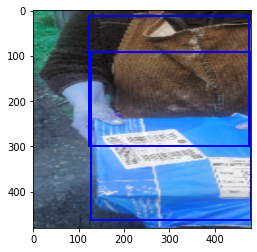

In [ ]:
# función para calcular accuracy 1:1
import os
from skimage import io, transform
import matplotlib.pyplot as plt


ml_model.to(device)
ml_model.eval()              # turn the model to evaluate mode
od_model.to(device)
od_model.eval()

# transformación para clasificador
transformations = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                      std=[0.229, 0.224, 0.225]),
                                                 ])
with torch.no_grad():
  fig, a = plt.subplots(1,1)
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Frimadariagao%40ttereyes.cl%2F149069566635.png?alt=media&token=6764bf1c-f8e7-493c-9194-42ec5f5ad7ec'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fraacevedo%40flopar.cl%2F149069331320.png?alt=media&token=770b7a57-f22f-40f7-9c34-6a41c2d1631d'
  url2 = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Figespinosa%40flopar.cl%2F149069510494.png?alt=media&token=07e1ceb4-2c58-4e64-88c6-123df2c8f6bb'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Figespinosa%40flopar.cl%2F14906952340301.png?alt=media&token=3bc3a521-640a-4c9e-947a-017fcb45d2b8'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fcrbello%40flopar.cl%2F149069579237.png?alt=media&token=ff5ece1b-b2b5-413f-9946-b77e2a93000b'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fmmonjev%40atenas.cl%2F149070535524.png?alt=media&token=1e855f19-d25f-4c78-b13b-e9dc737d9521'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fpacantillana%40atenas.cl%2F149070498375.png?alt=media&token=aad3d701-6636-4ff2-ba05-75f09fc37cd8'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fpagallegos%40transantino.cl%2F149070471763.png?alt=media&token=c09460a8-e0b2-4194-886b-48c0a31ceb7f'
  url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fpacortes%40transantino.cl%2F149070466427.png?alt=media&token=7fe9102b-b10e-4cd1-be63-dd6a1279850d'
  ur2 = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fsaolate%40flopar.cl%2F149069416542.png?alt=media&token=cdcc8f74-6343-42fd-825f-0424e74f1401'
  # leer url y obtener imagen
  url_open = urllib.request.urlopen(url2)
  image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
  image = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
  #-----------------------------------------------------------------------------
  # CLASIFICADOR MULTI-ETIQUETA
  # transformación para aplicar clasificador
  t_img = transformations(image)
  img = t_img.unsqueeze(dim = 0)
  # obtener clasificación
  label_base = ml_model(img.to(device))
  score = torch.sigmoid(label_base['label'])
  print(score)
  label = score.round()
  print(label)
  # lista de predicciones
  ml_prediction = label[0].tolist()
  #-----------------------------------------------------------------------------
  # DETECTOR DE OBJETOS
  # transformación para aplicar detector
  t_img = transform.resize(image, (480, 480))
  t_img = torch.Tensor(t_img).permute(2,0,1).to(device)
  od_prediction = od_model([t_img])

  if od_prediction[0]['labels'].shape[0] > 0 and max(od_prediction[0]['scores']).item() >= 0.5:
    pred_class = 1
  else:
    pred_class = 0  
  plt.imshow(t_img.permute(1,2,0).to('cpu'))
  boxes = od_prediction[0]['boxes'].to(device)
  scores = od_prediction[0]['scores']
  scores = torch.where(scores > 0.5, 1, 0)
  indice = 0
  for score in od_prediction[0]['scores']:
    if score >= 0.5:
      box = boxes[indice]
      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle(
          (x.item(), y.item()),
          width.item(), height.item(),
          linewidth = 2,
          edgecolor = 'b',
          facecolor = 'none'
          )
        # Draw the bounding box on top of the image
      print(type(a))
      a.add_patch(rect) 
    indice+=1  
  plt.show()

# Generar batch para imágenes


# 